# Suggestions for comparative analysis

**Date** : 2020-07-14<br>
**Description** : Some initial suggestions for methods to compare and highlight differences/similarities in the single cell mapping on the Visium slides. The data used to illustrate the concepts (method\_1 and method\_2) are just placeholders, i.e. they do not represent data from any real mapping. 

In [291]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the necessary modules

In [292]:
import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as Colormap
from scipy.stats import pearsonr

from typing import List,Union

Specify path to the (example) data and the name of the methods to be compared. The data is expected to be in a `h5ad`-format where the output from the methods are found in the `obsm` slot. 

In [293]:
DATA_PTH = "/home/alma/w-projects/stx/scripts/compare/synth-data/example-data-1.h5ad"
METHODS = ["method_1","method_2"]

Read data and inspect the file

In [294]:
data = ad.read_h5ad(DATA_PTH)
display(data)

AnnData object with n_obs × n_vars = 3571 × 31053
    obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y', 'xy', 'n_counts', 'sample', 'isocortex'
    var: 'n_counts'
    uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'
    obsm: 'method_1', 'method_2'

make sure the data is properly formatted and that the specified method's result are included. Remove cell types which are not present in all methods.

In [295]:
# make sure specified methods are included in data
methods = list(filter(lambda x: x in data.obsm.keys(),METHODS))
assert len(methods) == len(METHODS), "not all specified methods included in data"

# only analyze type
types = data.obsm[methods[0]].columns
for m in methods[1::]:
    types.intersection(data.obsm[m].columns)
    
n_types = len(types)
assert n_types > 0, "no common cell types"
for m in methods:
    data.obsm[m] = data.obsm[m][types]

Define a helper function to be used later, cleans up the plots.

In [296]:
def clean_ax(ax : plt.Axes,
             drop_spines : List[str] = ["all"],
             clean_ticks : bool = True,
            )->None:
    
    """helper function to clean up graphs"""
    
    if "all" in drop_spines:
        _drop_spines = ax.spines.keys()
    else:
        _drop_spines = drop_spines
        
    for side in _drop_spines:
        ax.spines[side].set_visible(False)
        
    if clean_ticks:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_yticklabels([])
        ax.set_xticklabels([])

## Assessing agreement between cell type mappings

To assess concordance between the (two) methods, look at how proportion estimates correlate (Pearson correlation) spatially. To visualize the result, we generate a scatterplot where x and y-coordinates represent the proportion estimate of respective method. We stratify by cell type, to see which types that the method infer similar/dissimilar spatial distributions of.

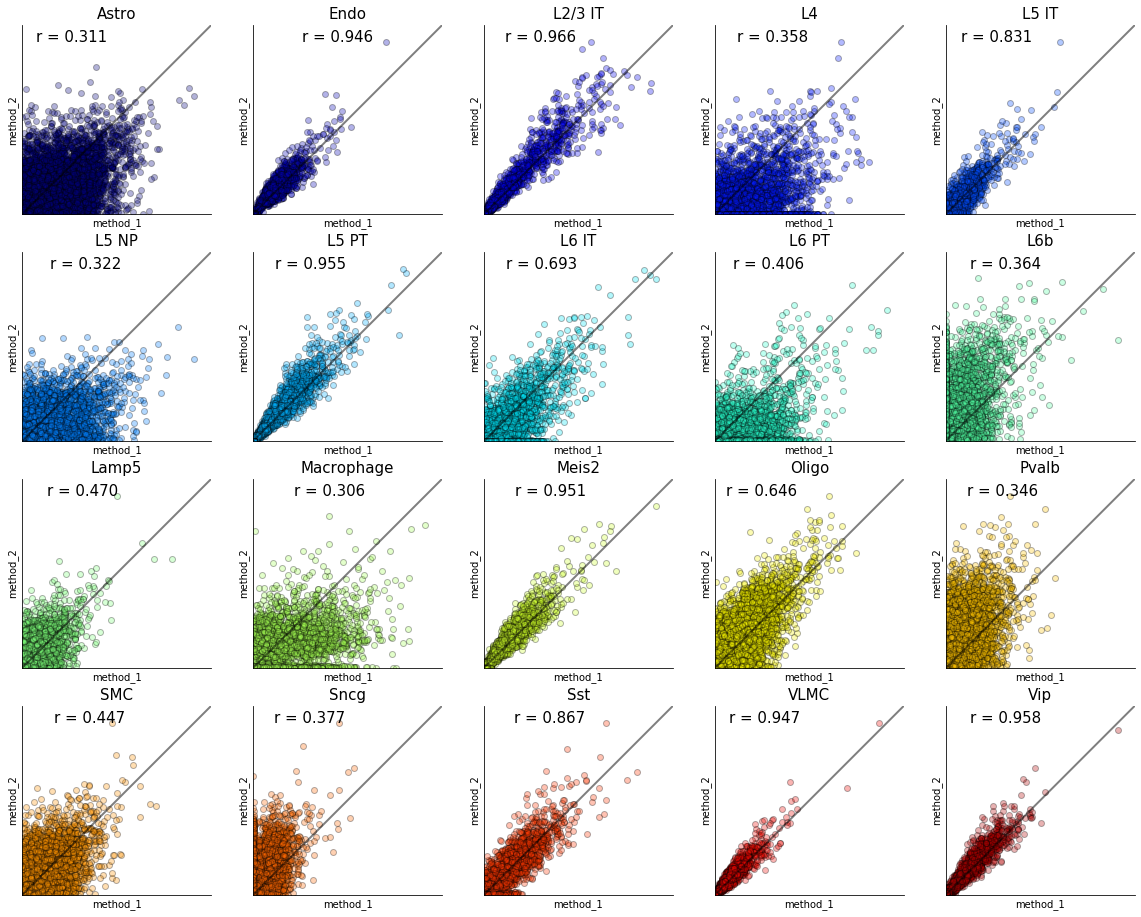

In [297]:
n_cols = 5
n_rows = np.ceil(n_types / 5).astype(int)
side_size = 4
cmap = plt.cm.jet

rvals = list()
pvals = list()

fig,ax = plt.subplots(n_rows,
                      n_cols,
                      figsize = (n_cols*side_size,n_rows * side_size))

ax = ax.flatten()

for k,ct in enumerate(types):
    xval = data.obsm[methods[0]][ct].values
    yval = data.obsm[methods[1]][ct].values
    
    color = np.array(cmap(k / len(types))).reshape(1,-1)
    
    mn =  0.9 * np.min((xval.min(),yval.min()))
    mx =  1.1 * np.max((xval.max(),yval.max()))
    
    refx = np.array((mn,mx))
    refy = np.array((mn,mx))
    
    ax[k].plot(refx,
               refy,
               color = "black",
               linewidth = 2,
               alpha = 0.5,
               )
    
    ax[k].scatter(xval,
                  yval,
                  c = color,
                  edgecolor = "black",
                  alpha = 0.3,
                 )
    
    clean_ax(ax[k],
             drop_spines=["right","top"])
    
    ax[k].set_title(ct, fontsize = 15)
    ax[k].set_xlabel(methods[0])
    ax[k].set_ylabel(methods[1])
    
    rval,pval = pearsonr(xval,yval)
    rvals.append(rval)
    pvals.append(pval)
    
    ax[k].text(x = (mn / 0.9) + 0.05,
               y = mx / 1.1,
               s = "r = {:0.3f}".format(rval),
               fontsize = 15,
              )
    
    
    ax[k].set_aspect("equal")
    ax[k].set_ylim((mn, mx))
    ax[k].set_xlim((mn, mx))
    
rvals = np.array(rvals)
pvals = np.array(pvals)
plt.show()

### Visualizing cell types with low and high agreement

To illustrate how cell types with different extent of agreement in the mapping from the two methods differ, we can visualize their respective proportion estimates together with their difference. The difference is given as: 
\begin{equation}
p_{spot,type,\textrm{method_1}} - p_{spot,type,\textrm{method_2}}
\end{equation}

<span style="color:red">Red</span> color indicates higher proportion values in method\_1, <span style="color:blue"> blue</span> values indicate higher values in method\_2.

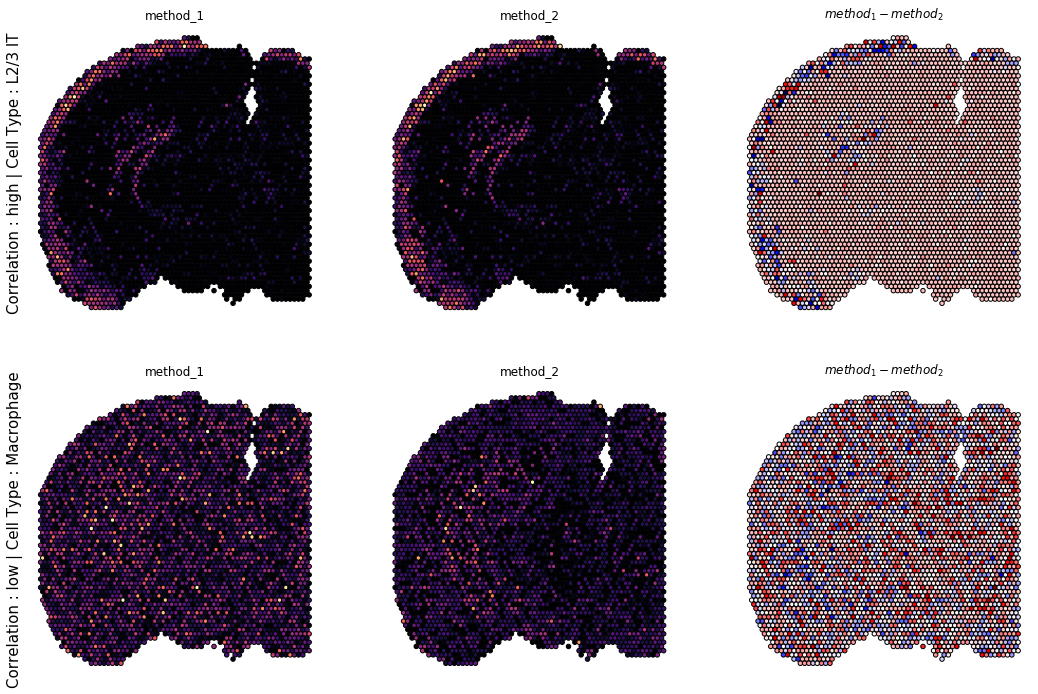

In [302]:
show_types = dict(high = types[np.argmax(rvals)],
                  low = types[np.argmin(rvals)],
                  )

n_cols = 3
n_rows = len(show_types)
side_size = 6

plt_args = {"s": 20,
            "edgecolor" : "black",
           }

xcrd = data.obs["x"].values
ycrd = data.obs["y"].values


fig, ax = plt.subplots(n_rows, n_cols,
                       figsize = (n_cols * side_size,
                                  n_rows * side_size,
                                 ),
                       
                      )

for k,(corr,ct) in enumerate(show_types.items()):
    
    vmin = np.min([data.obsm[m][ct].values.min() for m in methods])
    vmax = np.min([data.obsm[m][ct].values.max() for m in methods])
    
    diff = []
    for n,m in enumerate(methods):
        props = data.obsm[m][ct].values
        ax[k][n].scatter(ycrd,
                     xcrd,
                     c =  props,
                     cmap = plt.cm.magma,
                     vmin = vmin,
                     vmax = vmax,
                     **plt_args,
                     )
        ax[k][n].set_title(m)
        clean_ax(ax[k][n])

        diff.append(props)
        
    diff = diff[0] - diff[1]
        
    ax[k][2].scatter(ycrd,
                     xcrd,
                     c =  diff,
                     cmap = plt.cm.seismic,
                     **plt_args,
                     )
    
    clean_ax(ax[k][2])
    ax[k][2].set_title(r"${}-{}$".format(*methods))
    
    ax[k][0].set_ylabel("Correlation : {} | Cell Type : {}".format(corr,ct),
                       fontsize = 15,
                       )
    

for aa in ax.flatten() : aa.invert_yaxis()
    
plt.show()


## Convergence of results

The single cell mapping is by itself rarely the "end-goal" of our analysis, but rather we aim to use it for as input to some other analysis (e.g., looking at regional enrichment, co-localization patterns, etc.). Hence, while the raw proportion values are useful to quantify exactly how similar/different two mapping methods are, it might be also be relevant to compare the results from some basic "downstream" analyses. 

### Proportion by distance
We can for example look at how the LX ($X \in \{2,3,4,5,6\}$) cell type densities change as we move from the outer edge further into the isocortex, to see if similar trends are obtained between the two approaches, see the Figure below.

<img src="prop-by-position.png"> 

Begin by loading function from module to model proportion as function of distance to edge (`propbydist`), add paths for easier import (ugly, but works).

In [306]:
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
sys.path = list(set(sys.path))
from propbydist import *


Identify spots along the edge and compute distance for the remaining spots to the closest edge point. Inspect data to ensure all attributes are added properly.

In [308]:
add_edge_visium(data)
add_distance_to_edge(data)
display(data)

AnnData object with n_obs × n_vars = 3571 × 31053
    obs: 'barcodes', 'under_tissue', '_x', '_y', 'x', 'y', 'xy', 'n_counts', 'sample', 'isocortex', 'edge', 'edge_distance'
    var: 'n_counts'
    uns: 'fiducial_diameter_fullres', 'image_hires', 'spot_diameter_fullres', 'tissue_hires_scalef'
    obsm: 'method_1', 'method_2'

subset data (we are only interested in the isocortex as of now). Also visualize the edge along with distances to make sure selection is done properly.

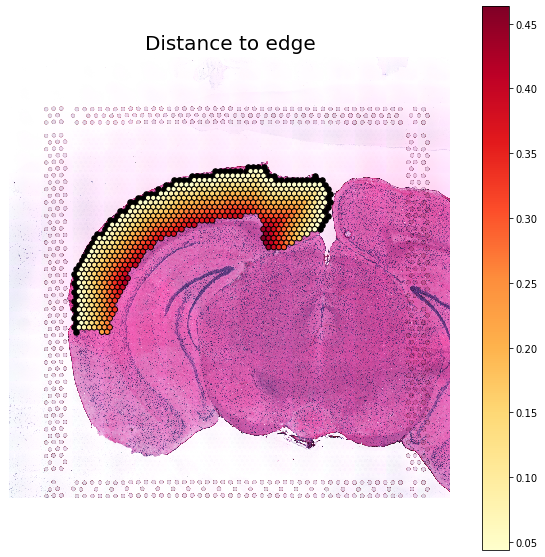

In [324]:
iso_data = data[data.obs["isocortex"].values == 1,:]

sf = iso_data.uns["tissue_hires_scalef"]
marker_size = 30

fig,ax = plt.subplots(1,1,figsize = (10,10))

is_edge = iso_data.obs["edge"] == 1
not_edge = iso_data.obs["edge"] == 0

ax.imshow(iso_data.uns["image_hires"])

ax.scatter(iso_data.obs["y"].values[is_edge]*sf,
           iso_data.obs["x"].values[is_edge]*sf,
           c = "black",
           s = marker_size,
          )

sc = ax.scatter(iso_data.obs["y"].values[not_edge]*sf,
           iso_data.obs["x"].values[not_edge]*sf,
           c = iso_data.obs["edge_distance"].values[not_edge],
           cmap = plt.cm.YlOrRd,
           s = marker_size,
           edgecolor = "black"
          )

ax.set_title("Distance to edge",fontsize =20)

clean_ax(ax)
fig.colorbar(sc)
plt.show()

We are only interested in the LX types, hence we'll confine our analysis to these types. We first identify cell types are a "layer type" and then generate their smoothed curves to plot.

In [332]:
layers = ["L{}".format(k) for k in range(2,7)]
layers = list(filter(lambda x : any( l in x for l in layers),types))


smoothed = dict()
for m in methods:
    _sl = smooth_layers(iso_data,
                        layers = layers,
                        prop_attr=("obsm",m))
    smoothed.update({m:_sl})

Visualize the results, y-axis will be the smoothed proprtion values and distance to edge on the x-axis. Method curves are (currently) indicated by solid and dashed lines respecively.

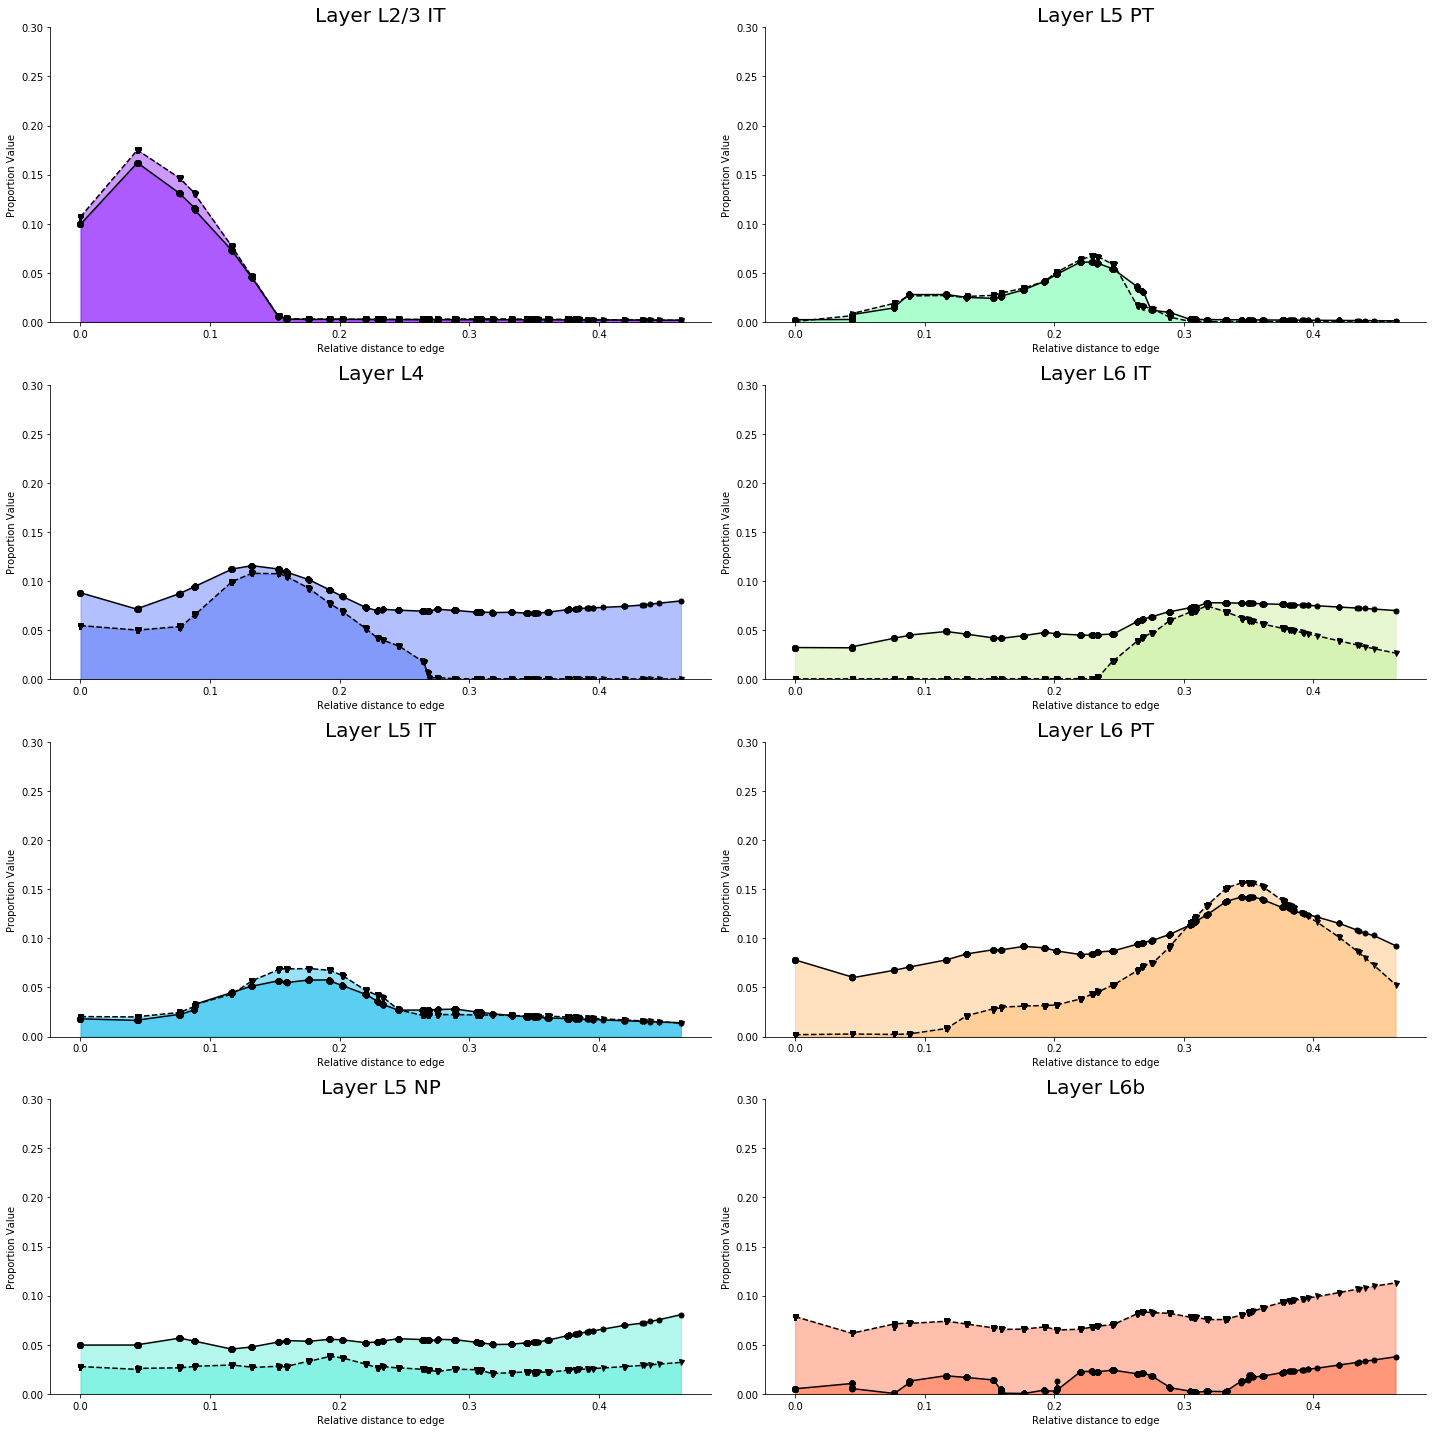

In [333]:
width = 10
height = 5
colormap = plt.cm.rainbow
colors = [colormap(l/len(layers)) for\
              l in range(len(layers))]

markers = ["-o","--v"]
markers = {mt:ma for mt,ma in zip(methods,markers)}

n_cols = 2
n_rows = int( np.ceil(len(layers)/n_cols) )
fig,ax = plt.subplots(nrows = n_rows,
                      ncols = n_cols,
                      figsize = (width * n_cols,
                                 height * n_rows),
                     )

ax = ax.flatten()[col_major_ordr(n_cols,n_rows)]

for m in methods:
    x_smooth = smoothed[m]["x_smooth"]
    y_smooth = smoothed[m]["y_smooth"]
    for k,layer in enumerate(layers):
            plot_smooth(ax[k],
                        x_smooth[k],
                        y_smooth[k],
                        linecolor = "black",
                        color = colors[k],
                        marker = markers[m],
                        markersize = 5,
                        )
            
            ax[k].set_title("Layer {}".format(layer),fontsize = 20)
            ax[k].set_ylim([0,0.3])

fig.tight_layout()


### Dominant cell type comparison

As an alternative to looking at _all_ cell types, we can also look at how the different methods assign a dominant cell type to each spot (i.e., which cell type that has the highest proportion value). The process follows as: 

1. For each cell type ($z$), we identify all spots ($S_{z}$) where this type is dominant in _either_ of the methods. 
2. Compute the fraction of spots in $S_z$ that are assigned to the same type


In [347]:
dominant_type = {m:types.values[np.argmax(data.obsm[m].values, axis = 1)] for m in methods}

comp_vals = np.zeros((n_types,3))

for k,ct in enumerate(types):
    idx_1 = np.where(dominant_type[methods[0]] == ct)[0]
    idx_2 = np.where(dominant_type[methods[1]] == ct)[0]
    
    idx = np.unique(np.append(idx_1,idx_2))
    comp = dominant_type[methods[0]][idx] == dominant_type[methods[1]][idx]
    
    comp_vals[k,0] = sum(comp)
    comp_vals[k,1] = len(comp)
    if comp_vals[k,1] > 0:
        comp_vals[k,2] = comp_vals[k,0] / comp_vals[k,1]
    

Next we visualize the result, dashed lines represent the quartile values (0.25,0.5 and 0.75) and are included as a reference. Opaque regions give the fraction of agreeing spots.

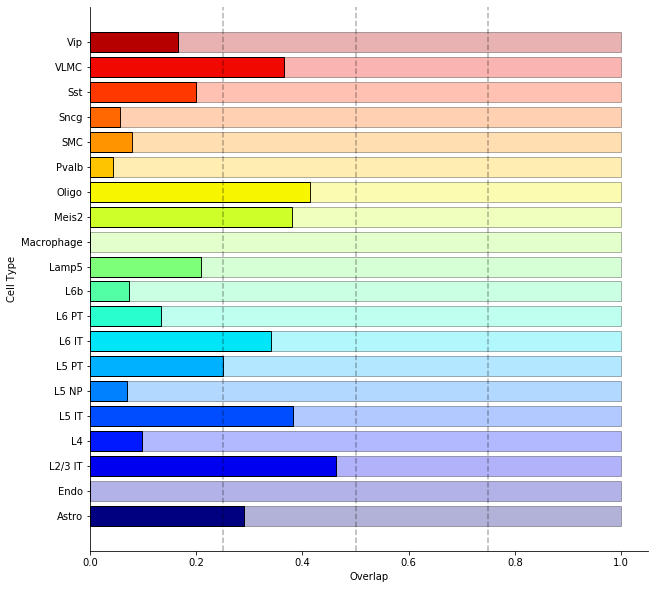

In [349]:
color = plt.cm.jet(np.arange(n_types)/n_types)

fig,ax = plt.subplots(1,
                      1,
                      figsize = (10,10))



ind = np.arange(comp_vals.shape[0])
ax.barh(ind, comp_vals[:,2],
        color = color,
        edgecolor = "black",
       )

ax.barh(ind, np.ones(ind.shape)- comp_vals[:,2],
        left = comp_vals[:,2],
        color = color,
        edgecolor = "black",
        alpha = 0.3)

ax.set_yticks(ind)
ax.set_yticklabels(types)

for _x in [0.25,0.5,0.75]:
    ax.axvline(_x,
               linestyle = "dashed",
               color = "black",
               alpha = 0.3,
              )

for sp in ["right","top"]:
    ax.spines[sp].set_visible(False)

ax.set_ylabel("Cell Type")
ax.set_xlabel("Overlap")
    
plt.show()

### Patterns of co-localization

We can assess how certain cell types co-localize by looking at their spot-wise Pearson correlation (w.r.t. proportions). First, we simply compute these values across both methods. We also define a helper function that allows us to plot these correlation matrices (`make_corr_plot`).

In [212]:
corrs = dict()
for m in methods:
    _corr = np.corrcoef(data.obsm[m].values.T)
    _ind = np.arange(_corr.shape[0])
    _corr[_ind,_ind] = np.nan
    corrs.update({m:_corr})


In [359]:
def make_corr_plot(ax : plt.Axes,
                   cmat : np.ndarray,
                   names : Union[pd.Index,List[str]],
                   cmap : Colormap = plt.cm.RdYlBu_r,
                   vmin : Union[None,float] = None,
                   vmax : Union[None,float] = None,
                   )->None:
    
    n_vars = names.shape[0]
    ax.imshow(cmat,
              origin = "lower",
              cmap = cmap,
              vmin = vmin,
              vmax = vmax,
             )
    
    ax.set_aspect("equal")
    ax.set_xticks(np.arange(0,n_vars))
    ax.set_yticks(np.arange(0,n_vars))
    ax.set_xticklabels(names.values,rotation = 90)
    ax.set_yticklabels(names.values)
    ax.set_xlim([-0.5,n_types-0.5])
    ax.set_ylim([-0.5,n_types-0.5])

We can now visualize the spatial co-localization patterns for our cell types from respective method, but also how these signals _differ_ between them. A simple way to compare how well our co-localization signals align, is simply to look at the relative error in our correlation matrices. More explicitly, we define the relative error matrix ($E = [e_{ij}]$) for correlation matrix $A = [a_{ij}]$ and $B = [b_{ij}]$ as:

\begin{equation}
e_{ij} = \frac{|a_{ij} - b_{ij}|}{\max(a_{ij},b_{ij})}
\end{equation}

_Note:_ There are probably better ways of doing this, but as a initial example this will do

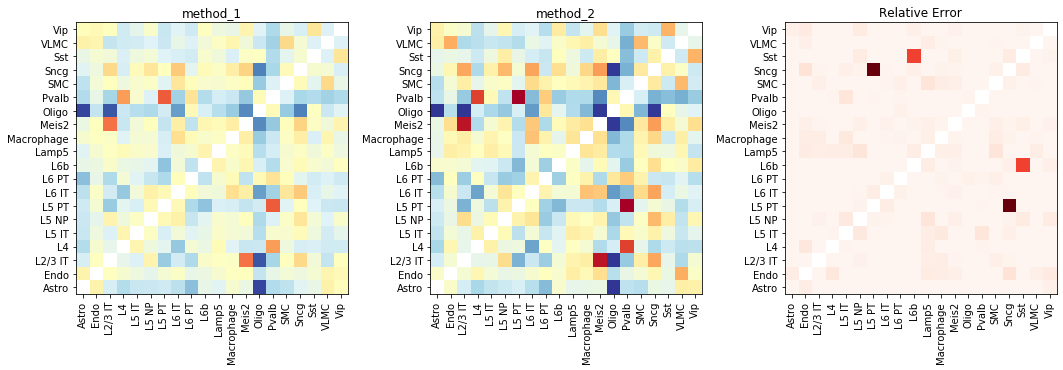

In [383]:
fig,ax = plt.subplots(1,3, figsize = (6 * 3, 5))
ax = ax.flatten()

vmin = np.min([np.nanmin(x) for x in corrs.values() ])
vmax = np.max([np.nanmax(x) for x in corrs.values() ])

for k,m in enumerate(methods):
    ax[k].set_title("{}".format(m))
    make_corr_plot(ax[k],
                  corrs[m],
                  types,
                  vmin = vmin,
                  vmax = vmax,
                 )
    
diff = np.abs(corrs[methods[0]] - corrs[methods[1]])


max_val = np.stack(list(corrs.values()),axis = 2)
max_val = np.max(max_val,axis=2)

diff_ratio = np.divide(diff,
                       max_val,
                       where = np.isnan(max_val) == False) 

make_corr(ax[2],
          diff_ratio,
          types,
          cmap = plt.cm.Reds,
          vmin = 0,
         )

ax[2].set_title("Relative Error")
plt.show()
